In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr

matplotlib.rcParams.update({'font.size': 14})
import dedalus.public as d3

import logging
logging.disable()

In [3]:
from frontal_zone import *

In [4]:
n_wavenumbers = 60; wavenumbers = 10. **np.linspace(-5, -2, n_wavenumbers)

## Sensitivity of growth rate $\Im\{\omega\}$ and instability scale $\lambda_{\text{max}}$ to frontal strength $M$

In [5]:
Mc = N*np.sqrt(np.sin(θ))
print(fr"We consider only subcritical fronts, i.e. with M < Mc = {round(Mc,7)}, which are gravitationally stable.")

Ms = np.array([3.e-5, 3.5e-5, 4.e-5, 4.4e-5, 4.44e-5, round(Mc*0.999, 9), Mc])

gr = xr.DataArray(np.zeros((n_wavenumbers, Ms.size)), coords={'wavenumber':wavenumbers, 'M':Ms,})
for M in Ms:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M)
        gr = gr.where(~((gr.M==M) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)
gr.to_netcdf("../../data/growth_rates/frontal_strength_M.nc")

We consider only subcritical fronts, i.e. with M < Mc = 4.47e-05, which are gravitationally stable.


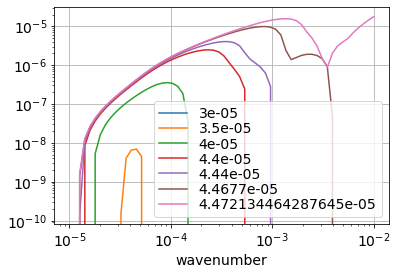

In [6]:
for M in gr.M:
    gr.sel(M=M).plot(label=M.values)
plt.yscale("log")
plt.xscale("log")
plt.legend(labelspacing=0.08)
plt.title("")
plt.grid(True)

## Sensitivity to frictional parameters ($\nu, \kappa, \nu_{h}, \kappa_{h}, \nu_{4}, \kappa_{4}$)

In [5]:
M = 4.e-5 

gr = xr.Dataset()
friction_scalings = np.array([0., 1.e-2, 1e-1, 1.e0, 1e1, 1.e2])

reference_friction = {
    "κ0":κ0, "κ1":κ1, "νh":5., "κh":0., "ν4":5.e5, "κ4":5.e2
}

##### Inviscid control

In [8]:
gr['inviscid'] = xr.DataArray(np.zeros((n_wavenumbers,)), coords={'wavenumber':wavenumbers,})
for n in wavenumbers:
    bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ0=1.e-8, κ1=0.)
    gr['inviscid'] = gr['inviscid'].where(~(gr.wavenumber==n), bfzi['omega'][bfzi['idx']].imag)

##### Only background slope-normal diffusivity and viscosity

In [9]:
gr['κ0_only'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ1=0., κ0=reference_friction["κ0"]*sc+1.e-8)
        gr['κ0_only'] = gr['κ0_only'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

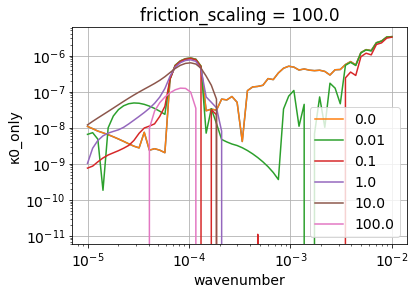

In [10]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['κ0_only'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()
plt.grid(True)

##### Variable bottom-enhancement of diffusivity and viscosity (on top of weak background)

In [11]:
gr['κ1'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ1=reference_friction["κ1"]*sc)
        gr['κ1'] = gr['κ1'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

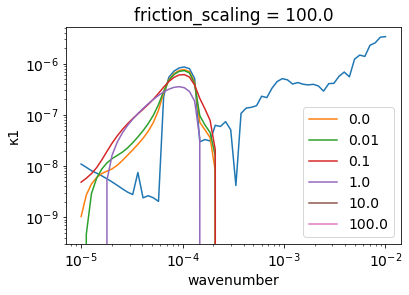

In [12]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['κ1'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

##### Variable horizontal Laplacian viscosity (w/ background diffusivities)

In [13]:
gr['νh'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, νh=reference_friction["νh"]*sc)
        gr['νh'] = gr['νh'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

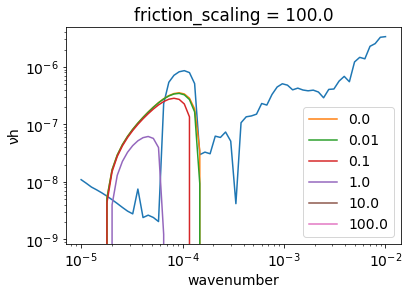

In [14]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['νh'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

##### Variable horizontal hyper-viscosity (w/ background diffusivities)

In [15]:
gr['ν4'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, ν4=reference_friction["ν4"]*sc)
        gr['ν4'] = gr['ν4'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

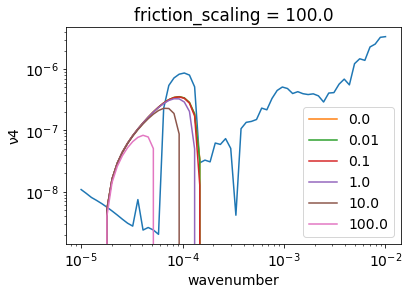

In [16]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['ν4'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

##### Variable horizontal hyper-diffusivity (w/ background diffusivities)

In [17]:
gr['κ4'] = xr.DataArray(np.zeros((n_wavenumbers, friction_scalings.size)), coords={'wavenumber':wavenumbers, 'friction_scaling':friction_scalings,})
for sc in friction_scalings:
    for n in wavenumbers:
        bfzi = bottom_frontal_zone_instability(0., 2*np.pi*n, M, κ4=reference_friction["κ4"]*sc)
        gr['κ4'] = gr['κ4'].where(~((gr.friction_scaling==sc) & (gr.wavenumber==n)), bfzi['omega'][bfzi['idx']].imag)

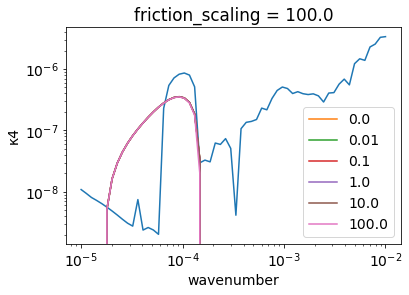

In [18]:
gr['inviscid'].plot()
plt.xscale("log")
plt.yscale("log")
for sc in friction_scalings:
    gr['κ4'].sel(friction_scaling=sc).plot(label=f"{sc}")
    
plt.legend()

##### Overly-viscous case

In [6]:
gr = xr.open_dataset("../../data/growth_rates/friction.nc")

In [7]:
gr['viscous'] = xr.DataArray(np.zeros((n_wavenumbers,)), coords={'wavenumber':wavenumbers,})
for n in wavenumbers:
    bfzi = bottom_frontal_zone_instability(
        0., 2*np.pi*n,
        M, νh=reference_friction["νh"], ν4=reference_friction["ν4"], κ4=reference_friction["κ4"]
    )
    gr['viscous'] = gr['viscous'].where(~(gr.wavenumber==n), bfzi['omega'][bfzi['idx']].imag)

### Saving calculations for post-processing

In [ ]:
gr.rename({'κ0_only':'k0_only', 'κ1':'k1', 'ν4':'nu4', 'νh':'nuh', 'κ4':'k4'}).to_netcdf("../../data/growth_rates/friction.nc")